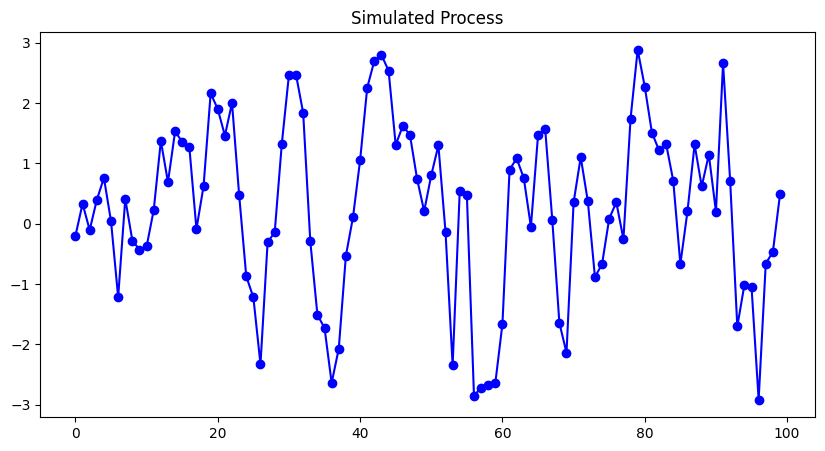

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Generate the data
import numpy as np
ar = np.array([1, -0.8, 0.2])
ma = np.array([1])
my_simulation = ArmaProcess(ar, ma).generate_sample(nsample=100)

plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(my_simulation, linestyle='-', marker='o', color='b')
plt.title("Simulated Process")
plt.show()

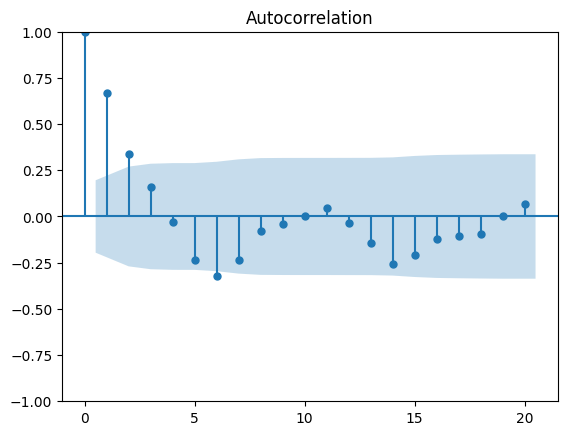

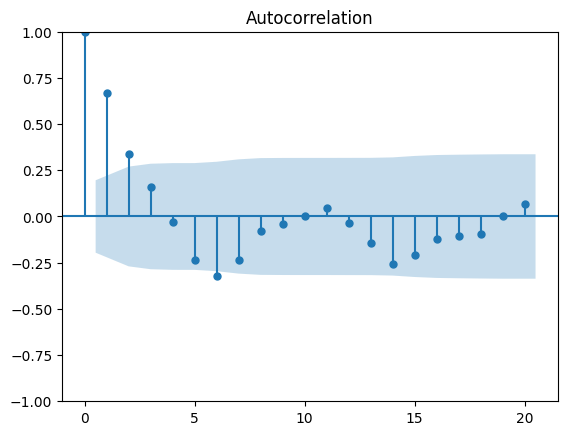

In [2]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
plot_acf(my_simulation)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


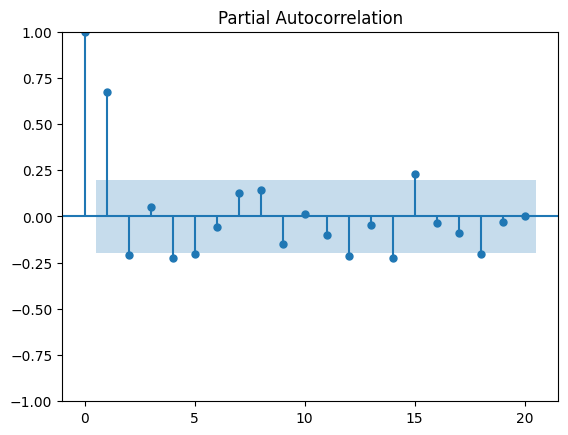

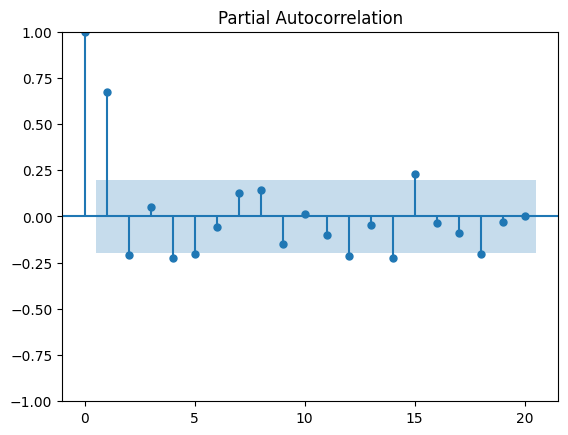

In [3]:
plot_pacf(my_simulation)

In [4]:
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

mod = sm.tsa.arima.ARIMA(my_simulation, order=(2, 0, 0))
mod_fit = mod.fit()
print(mod_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -145.653
Date:                Sat, 03 Jun 2023   AIC                            299.306
Time:                        09:05:29   BIC                            309.727
Sample:                             0   HQIC                           303.524
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2665      0.275      0.968      0.333      -0.273       0.806
ar.L1          0.8014      0.103      7.782      0.000       0.600       1.003
ar.L2         -0.2036      0.107     -1.906      0.0

In [6]:
import pandas as pd
import yfinance as yf

AMZN = yf.download('^IXIC', 
                      start='2015-01-01', 
                      end='2022-12-31', 
                      progress=False)

all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2015-01-02,4726.81,4760.24,4777.01,4698.11,4726.81,1435150000
2015-01-05,4652.57,4700.34,4702.77,4641.46,4652.57,1794470000
2015-01-06,4592.74,4666.85,4667.33,4567.59,4592.74,2167320000
2015-01-07,4650.47,4626.84,4652.72,4613.90,4650.47,1957950000
2015-01-08,4736.19,4689.54,4741.38,4688.02,4736.19,2105450000
2015-01-09,4704.07,4744.47,4744.71,4681.24,4704.07,1715830000
2015-01-12,4664.71,4714.07,4715.81,4650.65,4664.71,1861960000
2015-01-13,4661.50,4708.74,4751.34,4624.28,4661.50,2162180000
2015-01-14,4639.32,4610.76,4655.37,4595.98,4639.32,2073810000


In [7]:
print("There are "+ str(all_data[:'2020'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2021':].shape[0]) + " observations in the test data")

There are 1511 observations in the training data
There are 503 observations in the test data


In [8]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: 날짜를 인덱스로 갖는 주식 가격(Adj Close) 데이터
    output:
      X_train, y_train: 훈련용 데이터 
      X_test:  test 데이터(추세 파악)
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # training & test set 만들기기
    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # training 데이터의 samples와 time steps로 원본데이터 슬라이싱하기
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # 3차원 재구성(np.reshape(samples, time steps, features))
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    
    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(1505, 5)

In [9]:
# 3차원의 X_train을 데이터 프레임 형식으로 바꿔서 보기: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,4726.81,4652.57,4592.74,4650.47,4736.19,4704.07,4664.71
1,4652.57,4592.74,4650.47,4736.19,4704.07,4664.71,4661.50
2,4592.74,4650.47,4736.19,4704.07,4664.71,4661.50,4639.32
3,4650.47,4736.19,4704.07,4664.71,4661.50,4639.32,4570.82
4,4736.19,4704.07,4664.71,4661.50,4639.32,4570.82,4634.38
...,...,...,...,...,...,...,...
1500,12658.19,12764.75,12755.64,12742.52,12807.92,12771.11,12804.73
1501,12764.75,12755.64,12742.52,12807.92,12771.11,12804.73,12899.42
1502,12755.64,12742.52,12807.92,12771.11,12804.73,12899.42,12850.22
1503,12742.52,12807.92,12771.11,12804.73,12899.42,12850.22,12870.00


In [10]:
# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 보기 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4
0,12804.73,12899.42,12850.22,12870.00,12888.28
1,12899.42,12850.22,12870.00,12888.28,12698.45
2,12850.22,12870.00,12888.28,12698.45,12818.96
3,12870.00,12888.28,12698.45,12818.96,12740.79
4,12888.28,12698.45,12818.96,12740.79,13067.48
...,...,...,...,...,...
496,11170.89,10810.53,10705.41,10546.03,10547.11
497,10810.53,10705.41,10546.03,10547.11,10709.37
498,10705.41,10546.03,10547.11,10709.37,10476.12
499,10546.03,10547.11,10709.37,10476.12,10497.86


In [27]:
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))  #은닉 상태 값 32
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=["acc"])

    # fit the RNN model
    hist = my_rnn_model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return hist, my_rnn_model, rnn_predictions

hist, my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

16/16 [==============================] - 0s 2ms/step


array([[0.9712569 , 0.9665277 ],
       [0.9639058 , 0.97030795],
       [0.97035825, 0.9691289 ],
       [0.97953135, 0.9926455 ],
       [0.99068844, 1.0004214 ],
       [0.992243  , 0.9914806 ],
       [0.9763897 , 0.9844151 ],
       [0.9965207 , 1.0016848 ],
       [1.0059947 , 1.0071492 ]], dtype=float32)

입력 데이터가 정규화 되지 않아서 결과가 이상하게 나옴(정규화는 필수)

(179649550.0, <Axes: xlabel='Date'>)

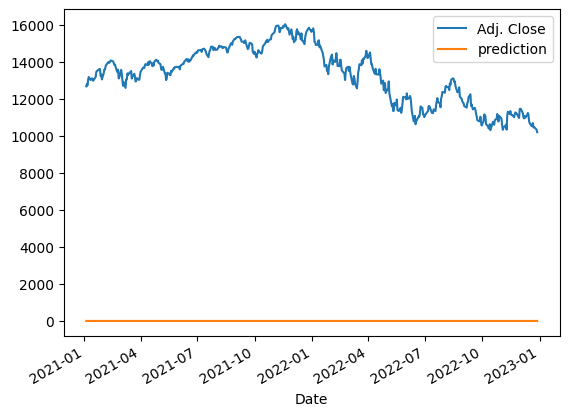

In [30]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2021':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions)  

16/16 [==============================] - 0s 2ms/step


(145102.39, <Axes: xlabel='Date'>)

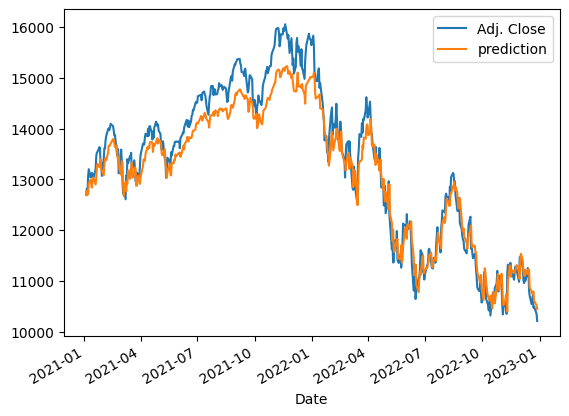

In [36]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # training & test set 만들기
    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data(데이터 정규화)
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    #training 데이터의 samples와 time steps로 원본데이터 슬라이싱하기
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # 3차원 재구성
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=["acc"])

    # fit the RNN model
    hist2 = my_rnn_model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return hist2, my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
hist2, my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2) 

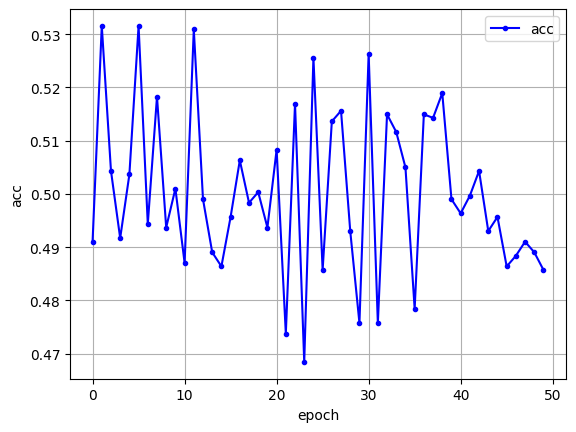

In [39]:
y_acc = hist2.history['acc']
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_acc, marker='.', c='blue', label="acc")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

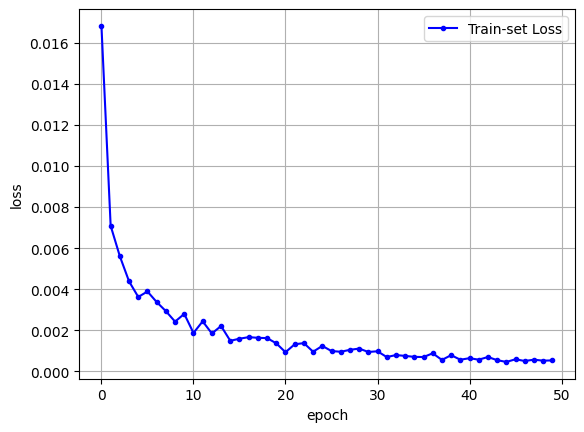

In [42]:
y_loss = hist2.history['loss']
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 1s 6ms/step


(452774.62, <Axes: xlabel='Date'>)

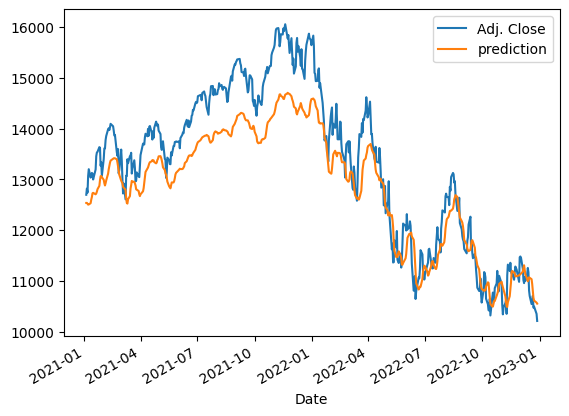

In [40]:
def LSTM_model(X_train, y_train, X_test, sc):
    # 모듈 불러오기
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # LSTM 아키텍쳐
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, momentum = 0.9, nesterov = False), loss = 'mean_squared_error', metrics=["acc"])
    
    # training data셋에 fitting(학습 시키는 것)
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 100, verbose = 0)
    
    # X_test를 LSTM 모델에 넣어서 예측
    LSTM_prediction = my_LSTM_model.predict(X_test)

    # 스케일러에 예측값 넣어 반환
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 3s 7ms/step


(459925.8, <Axes: xlabel='Date'>)

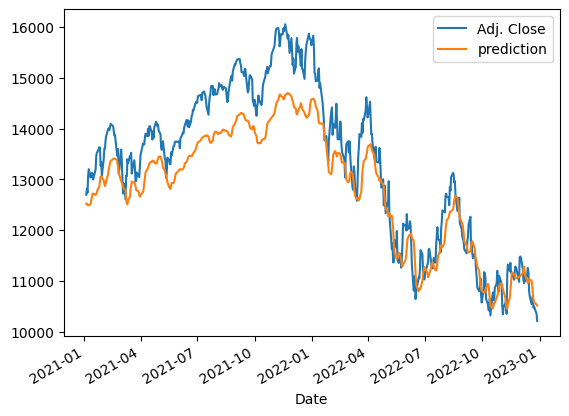

In [41]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout 
    from keras.optimizers import SGD 
    
    # LSTM 아키텍쳐 
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error', metrics=["acc"])
    
    # Fitting to the training set 
    hist = my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 100, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return hist, my_LSTM_model, LSTM_prediction 

hist, my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction) 

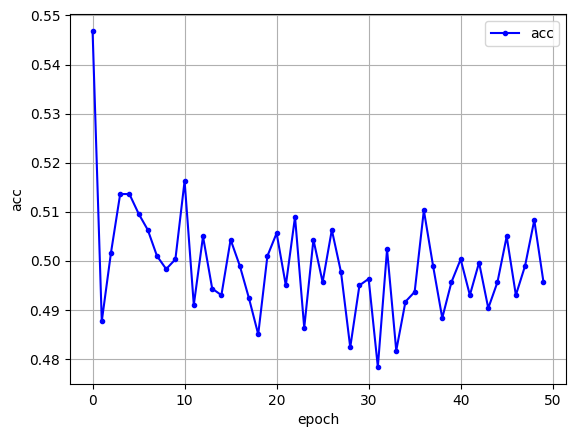

In [22]:
y_acc = hist.history['acc']
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_acc, marker='.', c='blue', label="acc")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

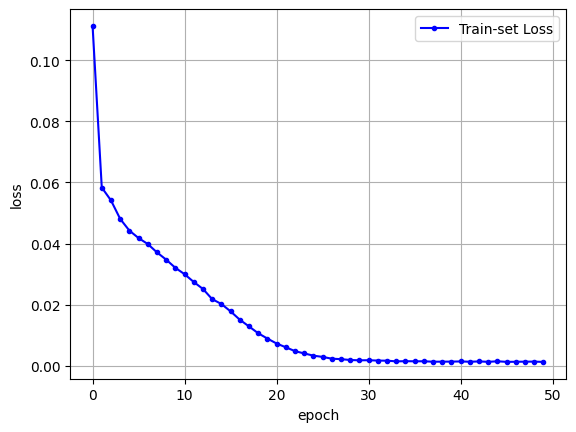

In [24]:
y_loss = hist.history['loss']
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 1s 3ms/step


(133578.0, <Axes: xlabel='Date'>)

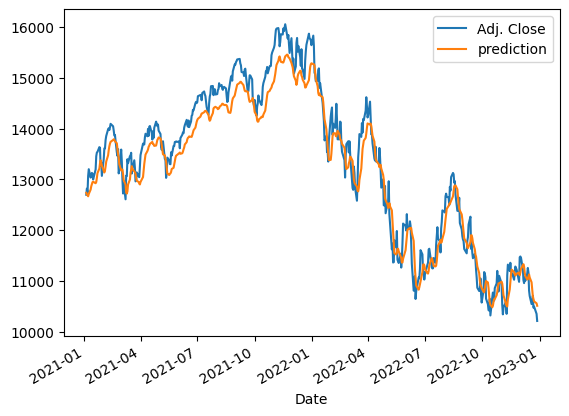

In [ ]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 3s 7ms/step


(119885.305, <Axes: xlabel='Date'>)

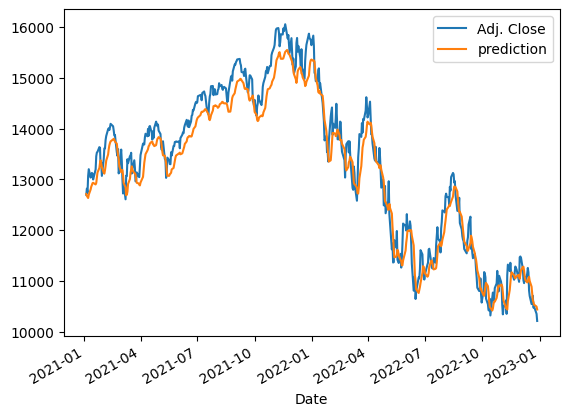

In [ ]:
def GRU_model_regularization(X_train, y_train, X_test, sc):
    """
    create a GRU model trained on X_train and y_train 
    and make predictions on the X_test data 
    """
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU, Dropout 
    from keras.optimizers import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    print("정확도: %.4f" % (my_GRU_model.evaluate()))
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)


In [ ]:
def accuracy(Original, Expectation):
  acc = list()
  for i in range(0, all_data['2021':].shape[0]):
    acc[i] = Original

In [ ]:
def MAE(Original, Expectation):
  n = float(0)
  #print(len(Expectation))
  for i in range(0, len(Original)):
    n += abs(Original[i]- Expectation[i])
  return n/len(Original)

def RMSE(Original, Expectation):
  n = float(0)
  #print(len(Expectation))
  for i in range(0, len(Original)):
    n += (Original[i]- Expectation[i])**2
  n = (n / len(Original)) ** (0.5)
  return n/len(Original)

def MAPE(Original, Expectation):
  n = float(0)
  for i in range(0, len(Original)):
    n += abs((Original[i]- Expectation[i])/ (Original[i]-10000)) * 100
  n /= len(Original)
  return n
#len(X_test_see)
#print(X_test_see[0])
#Original  = all_data['2021':].iloc[:,0:1].values
a_g = MAE(X_test_see[0], GRU_prediction)
a_l = MAE(X_test_see[0], LSTM_prediction)
print(a_g, a_l)
b_g = RMSE(X_test_see[0], GRU_prediction)
b_l = RMSE(X_test_see[0], LSTM_prediction)
print(b_g, b_l)
c_g = MAPE(X_test_see[0], GRU_prediction)
c_l = MAPE(X_test_see[0], LSTM_prediction)
print(100 - c_g, 100 - c_l)

[283.82947 310.45135] [635.38904 639.585  ]
[0.70225775 0.7502694 ] [1.4722582 1.4838059]
[88.94885 88.61276] [81.49985 81.43182]


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

def MAPE(y_test, y_pred):
	return np.mean(np.abs((X_test - GRU_prediction) / X_test)) * 100 
    
#print(mean_absolute_error(X_test, GRU_prediction))
#MSE = mean_squared_error(X_test, GRU_prediction)
#print(np.sqrt(MSE))
print(MAPE(X_test, GRU_prediction))

ValueError: ignored

In [ ]:
from sklearn.metrics import f1_score

# 데이터 스플릿으로 y_valid와 모델 예측으로 y_pred를 구한 후 실행
# 모델 검정이 없다면 y_true값으로 y_valid 대체
f1 = f1_score(X_test, GRU_prediction)
print(f1)

ValueError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
for i in range(len(GRU_prediction)):
  print(GRU_prediction[i])
  #print(LSTM_prediction[i])

[12676.898 12681.216]
[12650.67  12649.872]
[12630.977 12631.766]
[12609.69  12610.103]
[12652.806 12661.691]
[12737.634 12753.92 ]
[12805.832 12817.066]
[12845.284 12852.732]
[12890.549 12895.109]
[12897.1875 12901.835 ]
[12868.866 12871.921]
[12891.275 12897.229]
[12969.749 12983.832]
[13066.019 13084.643]
[13157.662 13175.193]
[13258.485 13272.861]
[13322.568 13333.52 ]
[13279.951 13280.583]
[13224.249 13222.326]
[13123.449 13116.298]
[13082.457 13084.815]
[13116.062 13131.293]
[13198.12  13215.601]
[13295.437 13315.639]
[13421.083 13438.445]
[13522.824 13540.862]
[13599.277 13616.816]
[13655.401 13668.727]
[13691.423 13703.297]
[13728.31  13740.772]
[13742.609 13754.372]
[13734.115 13742.897]
[13703.119 13707.491]
[13665.593 13669.382]
[13562.355 13559.688]
[13446.487 13441.193]
[13376.932 13377.098]
[13246.754 13240.242]
[13126.173 13121.521]
[13136.241 13143.661]
[13137.719 13146.142]
[13050.243 13050.888]
[12935.584 12922.447]
[12844.71  12833.492]
[12687.467 12678.428]
[12660.8